This notebook contains preliminary results using BERT base model on CORAAL dataset

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from utils import preprocessing

In [3]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [4]:
import utils

In [48]:
from utils import compute_metrics, compute_metrics_mult

In [6]:
from transformers import EarlyStoppingCallback

In [7]:
import evaluate

### Load Data

In [8]:
dat = pd.read_csv('../data/coraal/processed_coraal.tsv', sep='\t', index_col=0)

In [9]:
genders = dat.index.to_series().str.split(pat = '_', expand = True).iloc[:,3]

In [10]:
dat = pd.concat([dat, genders], axis = 1).rename(columns= {3:'gender'})

In [11]:
dat.head()

,text,location,gender
DCA_se1_ag1_f_01_1,My-My name is /RD-NAME-6/.One two three four f...,DCA,f
DCA_se1_ag2_f_01_1,"Baseball (laughing), marbles, you know. Uh, Ma...",DCA,f
DCA_se1_ag1_f_03_1,"Um, baseball, football, basketball, tennis, ki...",DCA,f
DCA_se2_ag1_f_07_1,"Mm, /let me see/. Do you want me to answer tha...",DCA,f
DCA_se3_ag1_f_03_1,I play hopscotch and kickball and sometimes we...,DCA,f


In [12]:
dat['pr_text'] = dat.text.apply(lambda x: preprocessing(x))

In [13]:
dat['pr_text'].iloc[0]

"my-my name is /rd-name-6/.one two three four five six seven eight nine ten.at home?i play uh, football, jump rope, that's all. we play double dutch.s- you have to uh- two people have- two people have to turn the rope.and you jump in the rope and start to jumping. no.yes.hide and seek.person gotta uh, count to twenty, and while the um, some more children hide, you got try to find 'em.i don't know. you sposta uh, say something like, i- uh- everybody put your feet in and somebody say they- they gonna be the namer and then you say b- something like uh, uh- say i forgot.mm-hm.i play d- i have- i have some /boxes/ games at home.don't spill the bean and i have a puzzle.and i have a game called /ergonaut/.it got some marbles with it and four dices and you sposta roll u- roll the dice and have some holes in it. and you- wherever you- where the dice stop at you sposta put the uh, marbles in the hole.you- it have four things down the row and then you get all four of your marbles down there, you 

In [14]:
#recode gender
dat.gender.replace({'f': 0, 'm': 1}, inplace=True)
dat.location_num = dat.location.replace({'DCA': 0, 'VLD': 1, 'DCB': 2, 'PRV': 3, 'LES': 4, 'ROC': 5, 'ATL': 6})

/tmp/ipykernel_109114/2061932604.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dat.location_num = dat.location.replace({'DCA': 0, 'VLD': 1, 'DCB': 2, 'PRV': 3, 'LES': 4, 'ROC': 5, 'ATL': 6})


### Train on whole CORAAL corpus to classify M vs F

- data size

In [15]:
dat.shape[0]

231

- Gender distribution

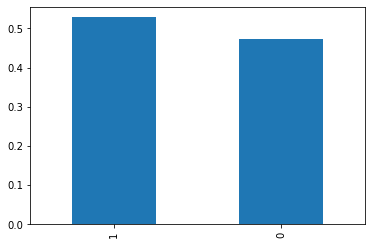

In [16]:
(dat.gender.value_counts()/len(dat)).plot.bar()
pass

In [17]:
#subdat.groupby(['gender','location']).size().plot.bar(figsize = (8,8))
#pass

#### Split training data

In [18]:
seed = 2022
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [19]:
dat['gender'].unique()

array([0, 1])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dat['pr_text'].to_list(), dat['gender'].to_list(), test_size = 0.2, random_state=2022)

#### Load BERT Model

In [21]:
model_name = 'bert-base-uncased'
max_length = 256
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length,return_tensors='pt')

In [22]:
# convert our tokenized data into a torch Dataset
train_dataset = utils.CoRAALDataSet(train_encodings, y_train)
test_dataset = utils.CoRAALDataSet(test_encodings, y_test)

In [23]:
target_names = dat['gender'].unique()

In [24]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
training_args = TrainingArguments(
    output_dir='./results-base',          # output directory
    num_train_epochs= 10,              # total number of training epochs
    per_device_train_batch_size= 1,  # batch size per device during training
    per_device_eval_batch_size= 1,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    learning_rate=1e-10,
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs-base',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=50,               # log & save weights each logging_steps
    save_steps=50,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    seed= 2022,
    data_seed=2022
)

In [26]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,   # the callback that computes metrics of interest
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [27]:
trainer.train()

/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 184
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1840
  Number of trainable parameters = 109483778
/home/sheng136/workspace/deDTN/code/utils.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.723900,0.727424,0.446809,0.000000,0.000000,0.000000
100,0.690200,0.727424,0.446809,0.000000,0.000000,0.000000
150,0.727200,0.727424,0.446809,0.000000,0.000000,0.000000
200,0.687600,0.727424,0.446809,0.000000,0.000000,0.000000
250,0.739100,0.727424,0.446809,0.000000,0.000000,0.000000
300,0.706000,0.727424,0.446809,0.000000,0.000000,0.000000
350,0.737700,0.727424,0.446809,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 47
  Batch size = 1
/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results-base/checkpoint-50
Configuration saved in ./results-base/checkpoint-50/config.json
Model weights saved in ./results-base/checkpoint-50/pytorch_model.bin
/home/sheng136/workspace/deDTN/code/utils.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 47
  Batch size = 1
/home/sheng136/miniconda3/envs/deDTN/lib/py

TrainOutput(global_step=350, training_loss=0.7159529549734933, metrics={'train_runtime': 52.257, 'train_samples_per_second': 35.211, 'train_steps_per_second': 35.211, 'total_flos': 46044434688000.0, 'train_loss': 0.7159529549734933, 'epoch': 1.9})

### Testing other existing methods
- load amazon_bert
- load stackover_bert

In [41]:
model_amazon = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names));
model_amazon.load_state_dict(torch.load('./models/amazon_bert/pytorch_model.bin'))
model_amazon.eval();

loading configuration file config.json from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/pytorch_model.bin
Some weights 

In [42]:
model_amazon.eval();

In [43]:
outputs = model_amazon(**test_encodings)
probs = outputs[0].softmax(1)
y_preds = probs.argmax(1)

In [44]:
y_preds

tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [45]:
metric_acc = evaluate.load('accuracy')

In [46]:
metric_acc.compute(predictions=y_preds, references=test_dataset.labels)

{'accuracy': 0.23404255319148937}

In [47]:
model_stackover = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))
model_stackover.load_state_dict(torch.load('./models/stackover_bert/pytorch_model.bin'))
model_stackover.eval();

loading configuration file config.json from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/pytorch_model.bin
Some weights 

In [48]:
outputs = model_stackover(**test_encodings)
probs = outputs[0].softmax(1)
y_preds = probs.argmax(1)

In [49]:
metric_acc.compute(predictions=y_preds, references=test_dataset.labels)

{'accuracy': 0.40425531914893614}

### Support Vector Machine

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.svm import SVC
ik
sklearn.model_selection import cross_val_score

- Considering limited data size, use K-Fold cross validation

In [52]:
X_train, X_test, y_train, y_test = train_test_split(dat['pr_text'].to_list(), dat['gender'].to_list(), test_size = 0.2, random_state=2022)

In [60]:
tfvec = TfidfVectorizer(ngram_range=(1,2),max_features=5000)

In [61]:
tfidf_train = tfvec.fit_transform(X_train)
tfidf_test = tfvec.fit_transform(X_test)

In [62]:
list(tfvec.vocabulary_)[1:10]

['you', 'taking', 'the', 'time', 'out', 'of', 'your', 'busy', 'day']

In [65]:
SVMclf = SVC(C=10, kernel='linear', degree=3, gamma='auto')

In [66]:
acc = cross_val_score(SVMclf, tfidf_train, y_train, cv=5, scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (acc.mean(), acc.std()))

0.86 accuracy with a standard deviation of 0.07


- Using C = 10, test set performance

In [67]:
from sklearn.metrics import accuracy_score

In [70]:
clf = SVC(C=10, kernel='linear', degree=3, gamma='auto').fit(tfidf_train, y_train)
svm_preds = clf.predict(tfidf_test)
accuracy_score(y_true=y_test,y_pred = svm_preds)

0.5531914893617021

## Predict provenance

In [28]:
dat.location.unique()

array(['DCA', 'VLD', 'DCB', 'PRV', 'LES', 'ROC', 'ATL'], dtype=object)

In [29]:
dat['location_num'] = dat.location.replace({'DCA': 0, 'VLD': 1, 'DCB': 2, 'PRV': 3, 'LES': 4, 'ROC': 5, 'ATL': 6},inplace=False)

In [30]:
target_names = dat.location_num.unique()

- Class distribution

In [31]:
dat.location_num.value_counts()

0    74
2    63
3    32
5    19
4    15
1    14
6    14
Name: location, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dat['pr_text'].to_list(), dat['location_num'].to_list(), test_size = 0.2, random_state=2022)

In [41]:
model_name = 'bert-base-uncased'
max_length = 256
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length,return_tensors='pt')

loading file vocab.txt from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient

In [42]:
# convert our tokenized data into a torch Dataset
train_dataset = utils.CoRAALDataSet(train_encodings, y_train)
test_dataset = utils.CoRAALDataSet(test_encodings, y_test)

In [43]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))

loading configuration file config.json from cache at /home/sheng136/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",

In [47]:
training_args = TrainingArguments(
    output_dir='./results-provonance',          # output directory
    num_train_epochs= 15,              # total number of training epochs
    per_device_train_batch_size= 1,  # batch size per device during training
    per_device_eval_batch_size= 1,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    learning_rate=1e-5,
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs-provonance',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    seed=2022,
    data_seed=2022
)

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [49]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,          # evaluation dataset
    compute_metrics=compute_metrics_mult,   # the callback that computes metrics of interest
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [50]:
trainer.train()

/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 184
  Num Epochs = 15
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2760
  Number of trainable parameters = 109487623


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.282900,1.045263,0.680851,0.680851,0.680851,0.680851
400,0.233700,1.123191,0.765957,0.765957,0.765957,0.765957
600,0.112100,0.989932,0.765957,0.765957,0.765957,0.765957
800,0.077800,1.110522,0.765957,0.765957,0.765957,0.765957
1000,0.031900,1.169299,0.723404,0.723404,0.723404,0.723404
1200,0.016200,1.059134,0.723404,0.723404,0.723404,0.723404
1400,0.004700,1.223259,0.808511,0.808511,0.808511,0.808511
1600,0.002800,0.980133,0.808511,0.808511,0.808511,0.808511
1800,0.002100,1.161932,0.765957,0.765957,0.765957,0.765957
2000,0.001700,1.157656,0.787234,0.787234,0.787234,0.787234


***** Running Evaluation *****
  Num examples = 47
  Batch size = 1
Saving model checkpoint to ./results-provonance/checkpoint-200
Configuration saved in ./results-provonance/checkpoint-200/config.json
Model weights saved in ./results-provonance/checkpoint-200/pytorch_model.bin
/home/sheng136/workspace/deDTN/code/utils.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 47
  Batch size = 1
Saving model checkpoint to ./results-provonance/checkpoint-400
Configuration saved in ./results-provonance/checkpoint-400/config.json
Model weights saved in ./results-provonance/checkpoint-400/pytorch_model.bin
/home/sheng136/workspace/deDTN/code/utils.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceT

TrainOutput(global_step=2600, training_loss=0.05925882034576856, metrics={'train_runtime': 190.35, 'train_samples_per_second': 14.5, 'train_steps_per_second': 14.5, 'total_flos': 342059727360000.0, 'train_loss': 0.05925882034576856, 'epoch': 14.13})